## Lab 4 - MNIST

For lab 4, you will complete and submit this ipynb to Canvas by the deadline.

Please see the posted Fashion-MNIST Jupyter Notebook. You should use it as the guideline to complete this Jupyter Notebook. There are many similarities, except a few places that you need to make modifications.

You will import the required modules, download the training/test data, use the dataloader, train the model (aim for at least 70% accuracy), and then use the model to test a few handwritten digits from the test dataset.

Every cell in this file must correspond to the similar cell in the same order in the fashion-MNIST file provided above. There is one optional cell at the every end, in case you would like to use it for more visualization, testing ... 

Add a comment to every line of code, and code segment (e.g. cell, branching, repetition, function, ...) of your code. Please refer to the pytorch documentation. This is meant to demonstrate some reasonable understanding of what is happing in the code.


In [107]:
# All the needed imports
import torch # the pytorch library, includes various useful functions
from torch import nn # import neural network from pytorch
from torch.utils.data import DataLoader # import the data loader utility from pytorch
from torchvision import datasets # import the datasets from torchvision (where we will use one of the datasets, MNIST)
from torchvision.transforms import ToTensor, Lambda, Compose # import various useful transformation functions from torchvision
import matplotlib.pyplot as plt # import matplotlib for plotting graphs

In [108]:
# Download training data from open datasets.
training_data = datasets.MNIST( # load data from MNIST dataset
    root="data", # the root for folder is data
    train=True, # want training data
    download=True, # want to download data
    transform=ToTensor(), # convert data to tensor form
)

# Download test data from open datasets.
test_data = datasets.MNIST( # load data from MNIST dataset
    root="data", # the root for folder is data
    train=False, # want nontraining/test data
    download=True, # want to download data
    transform=ToTensor(), # convert data to tensor form
)

In [109]:
# Create data loaders.

# of training examples used in one iteration
batch_size = 64

# sets up the dataloaders for train data
train_dataloader = DataLoader(training_data, batch_size=batch_size)
# sets up the dataloaders for test data
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# displays the dimensions of the data
for X, y in test_dataloader:
    # displays the shape of the input, [number of samples, types of pixels (1 for black and white), height, width]
    print("Shape of X [N, C, H, W]: ", X.shape)
    # displays the number of samples and batch size of the data
    print("Shape of y: ", y.shape, y.dtype)
    # once we know shape of entry, we can assume same dimensions for rest
    break


Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [110]:
# Get cpu or gpu device for training.
# if device supports cude, use it, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
# displays the selected device
print("Using {} device".format(device))

# Define an NN model
class NeuralNetwork(nn.Module):
    # NN constructor
    def __init__(self):
        # creates a model based on the basic neural network model
        super(NeuralNetwork, self).__init__()
        # defines the flatten function, which flattens to -1 for easier usage
        self.flatten = nn.Flatten()
        # defines the dimensions of the NN, and what layers it passes through
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512), # linear transformation used first, with our 28x28 image (so 28x28 input size) and 512 output size
            nn.ReLU(), # applies a element-wise rectified linear unit function
            nn.Linear(512, 512), # add linear transformation used first, with our 28x28 image (so 28x28 input size) and 512 output size
            nn.ReLU(), # applies another element-wise rectified linear unit function
            nn.Linear(512, 10) # add linear transformation used first, with our 28x28 image (so 28x28 input size) and 10 output size (for the 10 numbers 0-9)
        )
    # model forwarding method
    def forward(self, x):
        # performs previously defined flatten function
        x = self.flatten(x)
        # performs previously defined 'type of model' function
        logits = self.linear_relu_stack(x)
        # returns the model
        return logits
# sends the model to the best device, where cuda is preferred over cpu
model = NeuralNetwork().to(device)
# prints how the model looks like
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [111]:
# Set the loss and optimizer to be used in the next next cell
# defines the loss as a cross-entropy function - which builds upon entropy and generally calculates the difference between two probability distributions
loss_fn = nn.CrossEntropyLoss()
# defines the optimizer as a stochastic gradient descent, where the learning rate is 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [112]:
# Define the train and test functions
# the train function
def train(dataloader, model, loss_fn, optimizer):
    # gets the size of the dataset
    size = len(dataloader.dataset)
    # trains the model
    model.train()
    # for statement that cycles through each tensor in the dataloader
    for batch, (X, y) in enumerate(dataloader):
        # sends the tensor to the device for computation
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        # tells model that it is going to be trained
        pred = model(X)
        # uses the prediction error to calculate the cross entropy loss
        loss = loss_fn(pred, y)

        # Backpropagation
        # sets the gradients to zero
        optimizer.zero_grad()
        # computes gradeint of tensor with respect to graph leaves
        loss.backward()
        # performs parameter update based on current gradient and the update rule
        optimizer.step()

        # performs this function each time batch trains 100 images
        if batch % 100 == 0:
            # gets the current loss, gets the current batch length number * size of batch (in our case 64)
            loss, current = loss.item(), batch * len(X)
            # prints out the data in a formatted fashion
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# the test function
def test(dataloader, model, loss_fn):
    # gets the size of the dataset
    size = len(dataloader.dataset)
    # gets the number of batches
    num_batches = len(dataloader)
    # prepares the model for evaluation
    model.eval()
    # initilizes variables
    test_loss, correct = 0, 0
    # does this part without gradiant calculations
    with torch.no_grad():
        # for loop to iterate thorugh data entries
        for X, y in dataloader:
            # sends the data to the device
            X, y = X.to(device), y.to(device)
            # predicts each image
            pred = model(X)
            # adds the loss function's computation to the total loss
            test_loss += loss_fn(pred, y).item()
            # addes the computed correctness to the total amount of correctness
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # computes the average loss
    test_loss /= num_batches
    # computes the average correctness
    correct /= size
    # prints out formatted information
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [113]:
# Training the NN model 
# of passes of the entire training dataset that algorithm has completed
epochs = 10 # starting with 5 epochs --> may need to adjust
# iterate epoch number of times
for t in range(epochs):
    # print header for easier legibility
    print(f"Epoch {t+1}\n-------------------------------")
    # trains the model on train data
    train(train_dataloader, model, loss_fn, optimizer)
    # test the model on test data
    test(test_dataloader, model, loss_fn)
# print when epoch is done
print("Done!")

Epoch 1
-------------------------------
loss: 2.298764  [    0/60000]
loss: 2.302129  [ 6400/60000]
loss: 2.281877  [12800/60000]
loss: 2.283576  [19200/60000]
loss: 2.275968  [25600/60000]
loss: 2.278544  [32000/60000]
loss: 2.272368  [38400/60000]
loss: 2.274262  [44800/60000]
loss: 2.265929  [51200/60000]
loss: 2.249832  [57600/60000]
Test Error: 
 Accuracy: 52.3%, Avg loss: 2.251803 

Epoch 2
-------------------------------
loss: 2.252370  [    0/60000]
loss: 2.251752  [ 6400/60000]
loss: 2.240843  [12800/60000]
loss: 2.221786  [19200/60000]
loss: 2.226598  [25600/60000]
loss: 2.228179  [32000/60000]
loss: 2.211349  [38400/60000]
loss: 2.224940  [44800/60000]
loss: 2.202334  [51200/60000]
loss: 2.181723  [57600/60000]
Test Error: 
 Accuracy: 66.7%, Avg loss: 2.183801 

Epoch 3
-------------------------------
loss: 2.183800  [    0/60000]
loss: 2.177172  [ 6400/60000]
loss: 2.176991  [12800/60000]
loss: 2.127260  [19200/60000]
loss: 2.147084  [25600/60000]
loss: 2.144969  [32000/600

In [114]:
# Saving the model in a file, we will use it in the next cell
torch.save(model.state_dict(), "model.pth")
# print that model has been saved
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [118]:
# Using the model for some testing

# Test for at least three test cases
# creates new model of type Neural Network
model = NeuralNetwork()
# loades up the saved model
model.load_state_dict(torch.load("model.pth"))
# declare the number of classes of the model, where # of classes equal to the output size
classes = [
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9"
]

# sets up the model for evaluation
model.eval()
# iterate through first 30 test data entries
for i in range(30):
    # gets the image and expected predicted class
    x, y = test_data[i][0], test_data[i][1]
    # does this part without gradient calculations
    with torch.no_grad():
        # applies the model to x, to get a prediction
        pred = model(x)
        # translate the actual/prediction to the proper classes
        predicted, actual = classes[pred[0].argmax(0)], classes[y]
        # prints human-readable printout
        print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "7", Actual: "7"
Predicted: "2", Actual: "2"
Predicted: "1", Actual: "1"
Predicted: "0", Actual: "0"
Predicted: "4", Actual: "4"
Predicted: "1", Actual: "1"
Predicted: "9", Actual: "4"
Predicted: "4", Actual: "9"
Predicted: "6", Actual: "5"
Predicted: "9", Actual: "9"
Predicted: "0", Actual: "0"
Predicted: "2", Actual: "6"
Predicted: "9", Actual: "9"
Predicted: "0", Actual: "0"
Predicted: "1", Actual: "1"
Predicted: "3", Actual: "5"
Predicted: "9", Actual: "9"
Predicted: "7", Actual: "7"
Predicted: "3", Actual: "3"
Predicted: "4", Actual: "4"
Predicted: "7", Actual: "9"
Predicted: "6", Actual: "6"
Predicted: "6", Actual: "6"
Predicted: "5", Actual: "5"
Predicted: "4", Actual: "4"
Predicted: "0", Actual: "0"
Predicted: "7", Actual: "7"
Predicted: "4", Actual: "4"
Predicted: "0", Actual: "0"
Predicted: "1", Actual: "1"


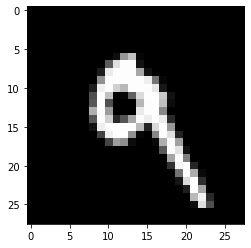

In [119]:
# Plot the test images used in the previous cell
plt.imshow(test_data[7][0].squeeze(), cmap = "gray")


In [120]:
# May include more testing and visualization here (optional)

